In [20]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# For plotting the classification results
from mlxtend.plotting import plot_decision_regions

In [21]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.2.0


### Surpress Warning Messages

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Data Wrangling and Utility Functions

In [22]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
    data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
    data['is_action'] = data.index.isin(action_doc_ids)
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

### Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix

1. Latent Semantic Analysis
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [23]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
            
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto'
                        ,eta='auto'
                        ,iterations=100
                        ,random_state=23
                        ,passes=20)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)
    
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

### Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest

In [90]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title,clusters,frame

def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()
        
    ## new
    elif model_type == 'knearest':
        print('kneighbors')
        model = KNeighborsClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions) 
    matrix = confusion_matrix(y_test, predictions) ## new
    report = classification_report(y_test, predictions) ## new
    
    dic = {'accy': accy, 'matrix': matrix, 'report': report}
    return dic



### Visualization Utility Functions

In [25]:
def plot_lsa(number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

### Loading the Class Corpus Data

In [26]:
#data = pd.read_csv('https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/ClassCorpus_Final_v5_20220717.csv')

In [33]:
CORPUS_PATH = 'https://raw.githubusercontent.com/djp840/MSDS_453_Public/main/MSDS453_ClassCorpus/ClassCorpus_Final_v5_20220717.csv'
data = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(data.Doc_ID, data.Text)]

In [34]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

In [35]:
data.head()

DSI_Title  \
Doc_ID                            
40      KCM_Doc1_AngelHasFallen   
41      KCM_Doc2_AngelHasFallen   
42      KCM_Doc3_AngelHasFallen   
43      KCM_Doc4_AngelHasFallen   
44      KCM_Doc5_AngelHasFallen   

                                                     Text  \
Doc_ID                                                      
40      Boredom sets in long before the start of Angel...   
41      \nWho ARE all these people?\n\nThat was what...   
42      Ric Roman Waughs Angel Has Fallen sees U.S. S...   
43      There is a certain mindless pleasure in the Fa...   
44      No, you dont need to have seen Olympus Has F...   

           Submission File Name Student Name Genre of Movie  \
Doc_ID                                                        
40      KCM_Doc1_AngelHasFallen          KCM         Action   
41      KCM_Doc2_AngelHasFallen          KCM         Action   
42      KCM_Doc3_AngelHasFallen          KCM         Action   
43      KCM_Doc4_AngelHasFallen          KCM         Action   
44      KCM_Doc5_AngelHasFallen          KCM         Action   

       Review Type (pos or neg)       Movie Title  \
Doc_ID                                              
40                     Negative  Angel Has Fallen   
41                     Negative  Angel Has Fallen   
42                     Negative  Angel Has Fallen   
43                     Negative  Angel Has Fallen   
44                     Negative  Angel Has Fallen   

                          Descriptor  Doc_ID  \
Doc_ID                                         
40      Action_Angel Has Fallen_N_40      40   
41      Action_Angel Has Fallen_N_41      41   
42      Action_Angel Has Fallen_N_42      42   
43      Action_Angel Has Fallen_N_43      43   
44      Action_Angel Has Fallen_N_44      44   

                                           processed_text  
Doc_ID                                                     
40      [boredom, start, angel, fallen, start, journey...  
41      [muttered, entered, first, screening, local, c...  
42      [roman, angel, fallen, secret, service, agent,...  
43      [certain, mindless, pleasure, fallen, movies, ...  
44      [andor, understand, eminently, disposable, thi...

In [38]:
print(data.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 40 to 199
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
 9   processed_text            200 non-null    object
dtypes: int64(1), object(9)
memory usage: 17.2+ KB
None


In [36]:
#getting all unique movie titles and genres

titles_genre = data[['Movie Title', 'Genre of Movie']].drop_duplicates().sort_values(by=['Genre of Movie'])
titles_genre

Movie Title Genre of Movie
Doc_ID                                  
40       Angel Has Fallen         Action
85              Inception         Action
125        No Time To Die         Action
5                   Taken         Action
160                  Taxi         Action
130        Legally Blonde         Comedy
140     Holmes and Watson         Comedy
70          The Lost City         Comedy
25        Despicable Me 3         Comedy
35          Dirty Grandpa         Comedy
95        Drag me to hell         Horror
100                 Fresh         Horror
175        It Chapter Two         Horror
65      The Toxic Avenger         Horror
185                    US         Horror
50               Oblivion         Sci-Fi
155                Batman         Sci-Fi
10            Equilibrium         Sci-Fi
115       Minority Report         Sci-Fi
191           Pitch Black         Sci-Fi

### Part 1: Clustering Experiments

In [37]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

/Users/tjgumingming/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### k = 15

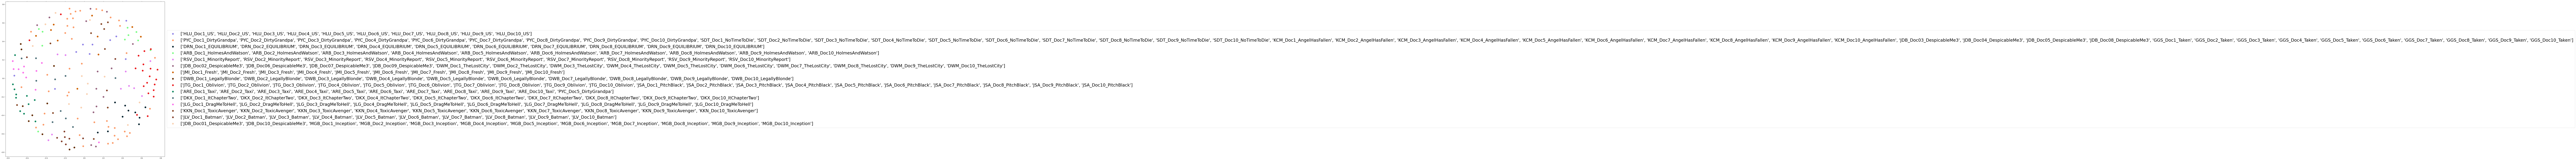

In [11]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =15)
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

### k = 10

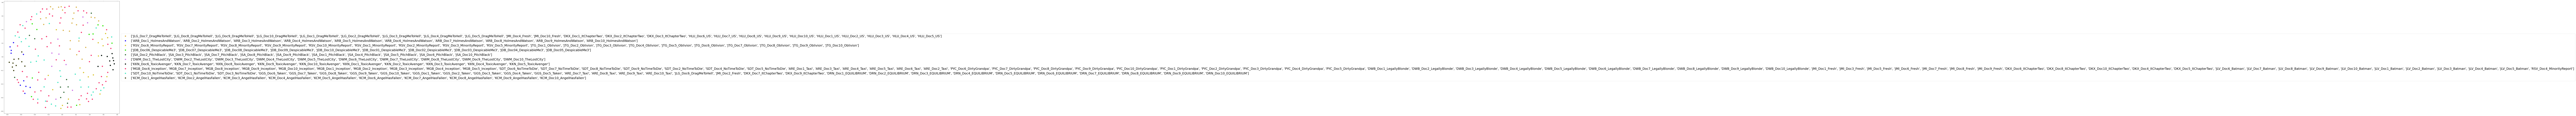

In [71]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =10)
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

### k = 20

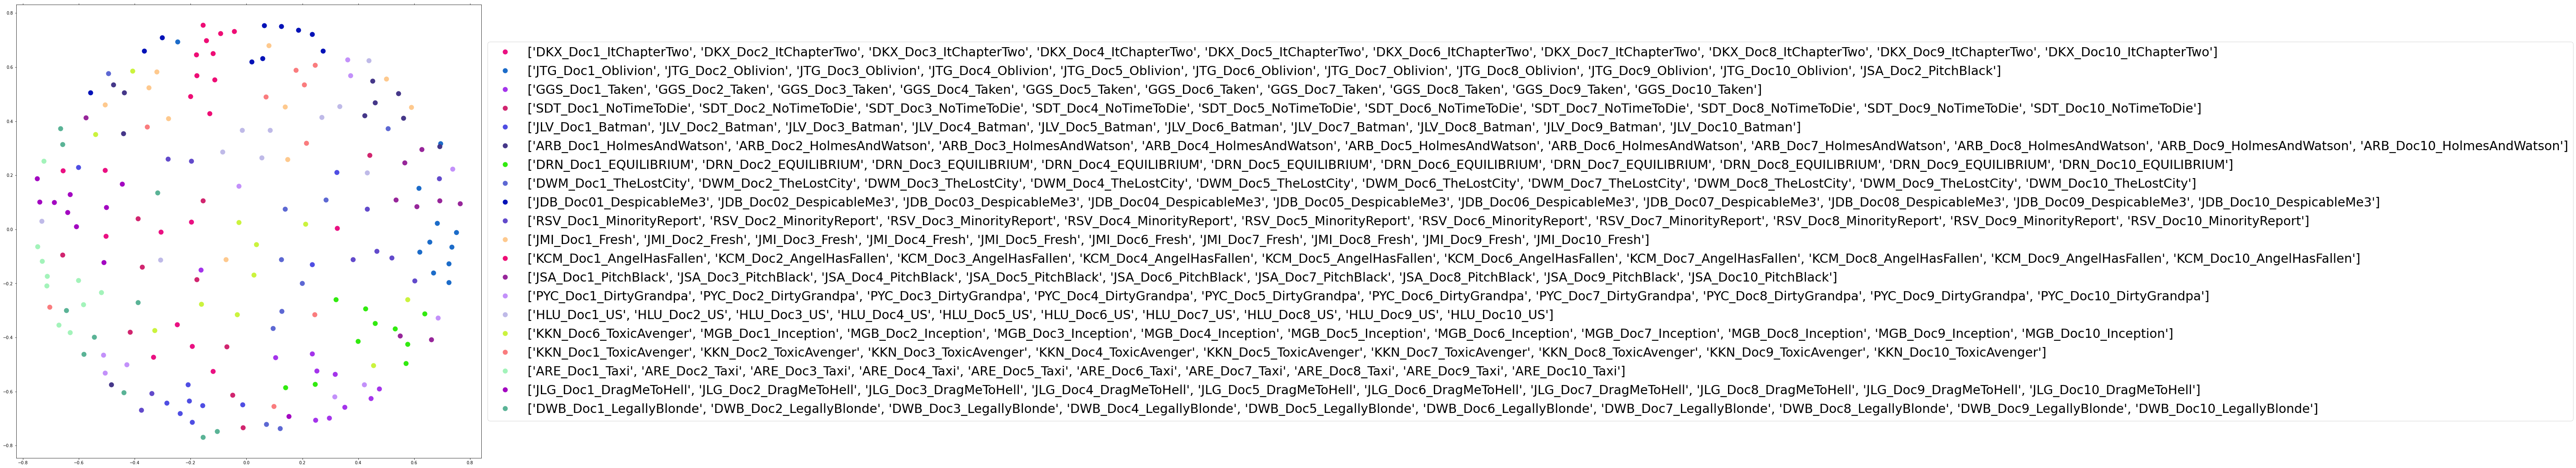

In [13]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =20)
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

### Part 2: Sentiment Analysis Experiments

### Generate Labels for Supervised Learning Models

In [73]:
# for sentiment 'pos' or 'neg'

labels0 = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels0)

Doc_ID
40     0
41     0
42     0
43     0
44     0
      ..
190    1
193    1
194    1
195    1
199    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


### Support Vector Machines

In [92]:
classifiers(tfidf_matrix, labels0, 'svm')

svm


/Users/tjgumingming/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tjgumingming/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tjgumingming/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

{'accy': 0.36363636363636365,
 'matrix': array([[24,  0],
        [42,  0]]),
 'report': '              precision    recall  f1-score   support\n\n           0       0.36      1.00      0.53        24\n           1       0.00      0.00      0.00        42\n\n    accuracy                           0.36        66\n   macro avg       0.18      0.50      0.27        66\nweighted avg       0.13      0.36      0.19        66\n'}

### Logistic Regression Model

In [93]:
classifiers(tfidf_matrix, labels0, 'logistic')

logistic


{'accy': 0.3484848484848485,
 'matrix': array([[23,  1],
        [42,  0]]),
 'report': '              precision    recall  f1-score   support\n\n           0       0.35      0.96      0.52        24\n           1       0.00      0.00      0.00        42\n\n    accuracy                           0.35        66\n   macro avg       0.18      0.48      0.26        66\nweighted avg       0.13      0.35      0.19        66\n'}

### Naive Bayes

In [94]:
classifiers(tfidf_matrix, labels0, 'naive_bayes')

naive_bayes


{'accy': 0.36363636363636365,
 'matrix': array([[23,  1],
        [41,  1]]),
 'report': '              precision    recall  f1-score   support\n\n           0       0.36      0.96      0.52        24\n           1       0.50      0.02      0.05        42\n\n    accuracy                           0.36        66\n   macro avg       0.43      0.49      0.28        66\nweighted avg       0.45      0.36      0.22        66\n'}

### Random Forest

In [98]:
classifiers(tfidf_matrix, labels0, 'randomforest')

randomforest


{'accy': 0.3939393939393939,
 'matrix': array([[22,  2],
        [38,  4]]),
 'report': '              precision    recall  f1-score   support\n\n           0       0.37      0.92      0.52        24\n           1       0.67      0.10      0.17        42\n\n    accuracy                           0.39        66\n   macro avg       0.52      0.51      0.35        66\nweighted avg       0.56      0.39      0.30        66\n'}

### Part 3. Multi-class Classification Experiments

### Generate Labels for Supervised Learning Models

In [56]:
# for genre

labels = data['Genre of Movie'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'action' 
                                      else (1 if x.lower().split(' ')[0] == 'comedy' else (2 if x.lower().split(' ')[0] == 'horror' else 3))
    
                                     )
print(labels)

Doc_ID
40     0
41     0
42     0
43     0
44     0
      ..
190    3
193    3
194    3
195    3
199    3
Name: Genre of Movie, Length: 200, dtype: int64


In [53]:
data['Genre of Movie'].unique()

array(['Action', 'Comedy', 'Horror', 'Sci-Fi'], dtype=object)

### Support Vector Machines

In [100]:

classifiers(tfidf_matrix, labels, 'svm')

svm


/Users/tjgumingming/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tjgumingming/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tjgumingming/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

{'accy': 0.36363636363636365,
 'matrix': array([[24,  0],
        [42,  0]]),
 'report': '              precision    recall  f1-score   support\n\n           0       0.36      1.00      0.53        24\n           1       0.00      0.00      0.00        42\n\n    accuracy                           0.36        66\n   macro avg       0.18      0.50      0.27        66\nweighted avg       0.13      0.36      0.19        66\n'}

### K Nearest Neighbors

In [104]:
classifiers(tfidf_matrix, labels, 'knearest')

kneighbors


{'accy': 0.3333333333333333,
 'matrix': array([[13, 11],
        [33,  9]]),
 'report': '              precision    recall  f1-score   support\n\n           0       0.28      0.54      0.37        24\n           1       0.45      0.21      0.29        42\n\n    accuracy                           0.33        66\n   macro avg       0.37      0.38      0.33        66\nweighted avg       0.39      0.33      0.32        66\n'}

### Logistic Regression Model

In [101]:
### not applied for genre
classifiers(tfidf_matrix, labels, 'logistic')

logistic


{'accy': 0.3484848484848485,
 'matrix': array([[23,  1],
        [42,  0]]),
 'report': '              precision    recall  f1-score   support\n\n           0       0.35      0.96      0.52        24\n           1       0.00      0.00      0.00        42\n\n    accuracy                           0.35        66\n   macro avg       0.18      0.48      0.26        66\nweighted avg       0.13      0.35      0.19        66\n'}

###  Naive Bayes

In [102]:

classifiers(tfidf_matrix, labels, 'naive_bayes')

naive_bayes


{'accy': 0.36363636363636365,
 'matrix': array([[23,  1],
        [41,  1]]),
 'report': '              precision    recall  f1-score   support\n\n           0       0.36      0.96      0.52        24\n           1       0.50      0.02      0.05        42\n\n    accuracy                           0.36        66\n   macro avg       0.43      0.49      0.28        66\nweighted avg       0.45      0.36      0.22        66\n'}

### Random Forest

In [103]:
classifiers(tfidf_matrix, labels, 'randomforest')

randomforest


{'accy': 0.3787878787878788,
 'matrix': array([[23,  1],
        [40,  2]]),
 'report': '              precision    recall  f1-score   support\n\n           0       0.37      0.96      0.53        24\n           1       0.67      0.05      0.09        42\n\n    accuracy                           0.38        66\n   macro avg       0.52      0.50      0.31        66\nweighted avg       0.56      0.38      0.25        66\n'}

### Silhouette Score

In [14]:
#X = final_processed_text

silhouette_score(X, labels, metric = 'euclidean')

NameError: name 'X' is not defined

In [15]:
np.dtype(k_means_df['Cluster'])

dtype('int64')

In [16]:
X = k_means_df[['Text', 'Cluster']].values

In [17]:
labels = k_means_df['Cluster']

In [18]:
k_means_df

Cluster             Doc Name  \
0         17        ARE_Doc1_Taxi   
1         17        ARE_Doc2_Taxi   
2         17        ARE_Doc3_Taxi   
3         17        ARE_Doc4_Taxi   
4         17        ARE_Doc5_Taxi   
..       ...                  ...   
195       15   MGB_Doc6_Inception   
196       15   MGB_Doc7_Inception   
197       15   MGB_Doc8_Inception   
198       15   MGB_Doc9_Inception   
199       15  MGB_Doc10_Inception   

                                                  Text  
0    jimmy fallons screen career started complete s...  
1    getting nominated chicago making boxoffice spl...  
2    queen latifah handily walked inêchicago enlive...  
3    jimmy fallon leaves òsaturday night liveó imme...  
4    taxiêcasts jimmyêfallon officer washburn bumbl...  
..                                                 ...  
195  inception makes average moviegoer smart would ...  
196  basic story money spectacular inception consta...  
197  unless movie masterpiece limit gotta quick spo...  
198  reading amazing reviews seeing score movie wat...  
199  shame movie rated highly movie masterpiece doe...  

[200 rows x 3 columns]

### Part 4: Topic Modeling Experiments

### Latent Semantic Analysis - Research Number of Topics and Number of Words

### Plotting 2 topics and 10 words

[(0, '0.427*"movie" + 0.187*"would" + 0.173*"action" + 0.143*"equilibrium" + 0.143*"first" + 0.142*"movies" + 0.123*"scene" + 0.111*"people" + 0.110*"scenes" + 0.109*"story"'), (1, '-0.435*"anderton" + -0.285*"minority" + -0.261*"report" + -0.211*"precrime" + -0.209*"spielberg" + 0.199*"movie" + -0.174*"technology" + -0.154*"future" + 0.131*"equilibrium" + 0.096*"matrix"')]


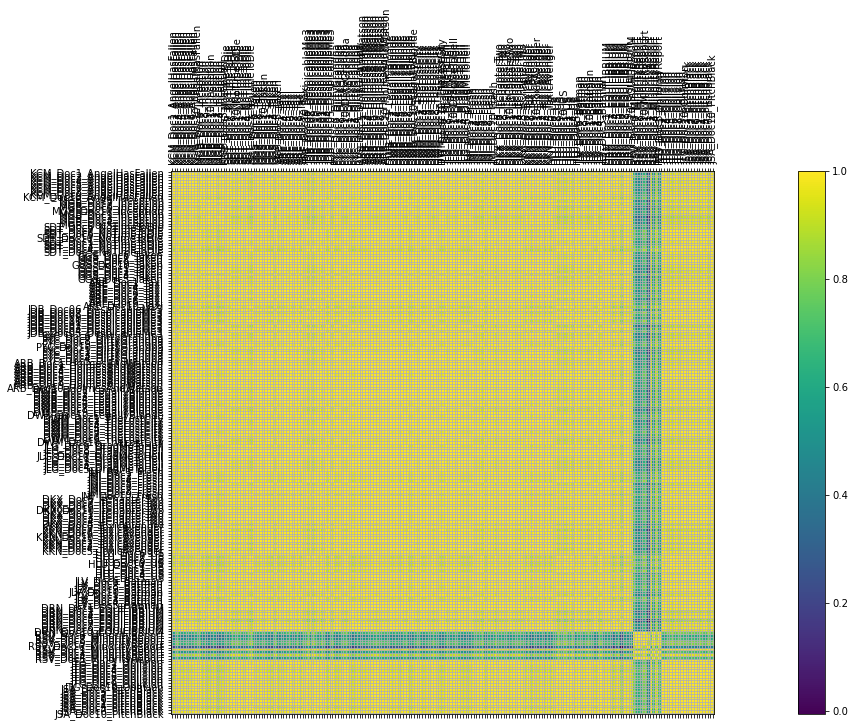

In [39]:

model_2topic_10words = plot_lsa(2, 10)

### Plotting 6 topics and 10 words

[(0, '0.427*"movie" + 0.187*"would" + 0.173*"action" + 0.143*"equilibrium" + 0.143*"first" + 0.142*"movies" + 0.123*"scene" + 0.111*"people" + 0.110*"scenes" + 0.109*"story"'), (1, '0.435*"anderton" + 0.285*"minority" + 0.261*"report" + 0.211*"precrime" + 0.209*"spielberg" + -0.199*"movie" + 0.174*"technology" + 0.154*"future" + -0.131*"equilibrium" + -0.096*"matrix"'), (2, '0.366*"equilibrium" + 0.232*"matrix" + 0.189*"preston" + 0.128*"anderton" + 0.127*"christian" + -0.125*"horror" + -0.116*"batman" + 0.115*"cleric" + -0.094*"makes" + 0.094*"scene"'), (3, '0.469*"movie" + -0.276*"preston" + -0.207*"batman" + -0.154*"equilibrium" + -0.148*"world" + -0.147*"action" + 0.128*"toxic" + -0.127*"emotions" + 0.114*"movies" + -0.112*"sense"'), (4, '0.537*"batman" + 0.292*"joker" + 0.209*"bruce" + 0.175*"keaton" + 0.171*"gotham" + 0.170*"wayne" + 0.141*"nicholson" + 0.128*"movie" + 0.124*"burton" + 0.123*"vicki"'), (5, '0.366*"toxic" + 0.225*"horror" + 0.217*"avenger" + -0.199*"action" + -0.1

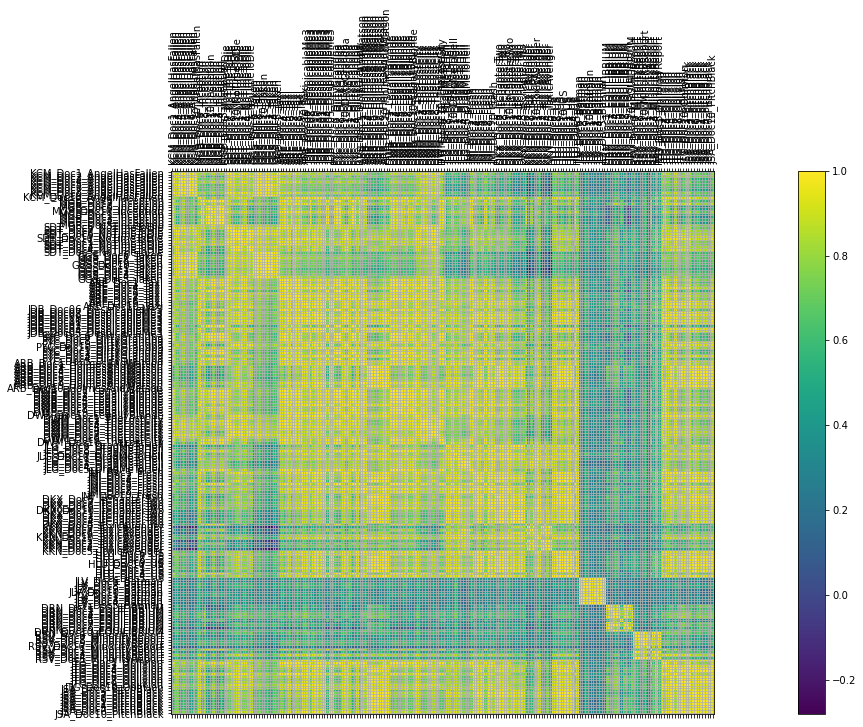

In [41]:

model_6topic_10words = plot_lsa(6, 10)

### Plotting 20 topics and 10 words

[(0, '0.427*"movie" + 0.187*"would" + 0.173*"action" + 0.143*"equilibrium" + 0.143*"first" + 0.142*"movies" + 0.123*"scene" + 0.111*"people" + 0.110*"scenes" + 0.109*"story"'), (1, '-0.435*"anderton" + -0.285*"minority" + -0.261*"report" + -0.211*"precrime" + -0.209*"spielberg" + 0.199*"movie" + -0.174*"technology" + -0.154*"future" + 0.131*"equilibrium" + 0.096*"matrix"'), (2, '-0.366*"equilibrium" + -0.232*"matrix" + -0.189*"preston" + -0.128*"anderton" + -0.127*"christian" + 0.125*"horror" + 0.116*"batman" + -0.115*"cleric" + 0.094*"makes" + -0.094*"scene"'), (3, '0.469*"movie" + -0.276*"preston" + -0.207*"batman" + -0.154*"equilibrium" + -0.148*"world" + -0.147*"action" + 0.128*"toxic" + -0.127*"emotions" + 0.114*"movies" + -0.112*"sense"'), (4, '-0.537*"batman" + -0.292*"joker" + -0.209*"bruce" + -0.175*"keaton" + -0.171*"gotham" + -0.170*"wayne" + -0.141*"nicholson" + -0.128*"movie" + -0.124*"burton" + -0.123*"vicki"'), (5, '0.366*"toxic" + 0.225*"horror" + 0.217*"avenger" + -0.1

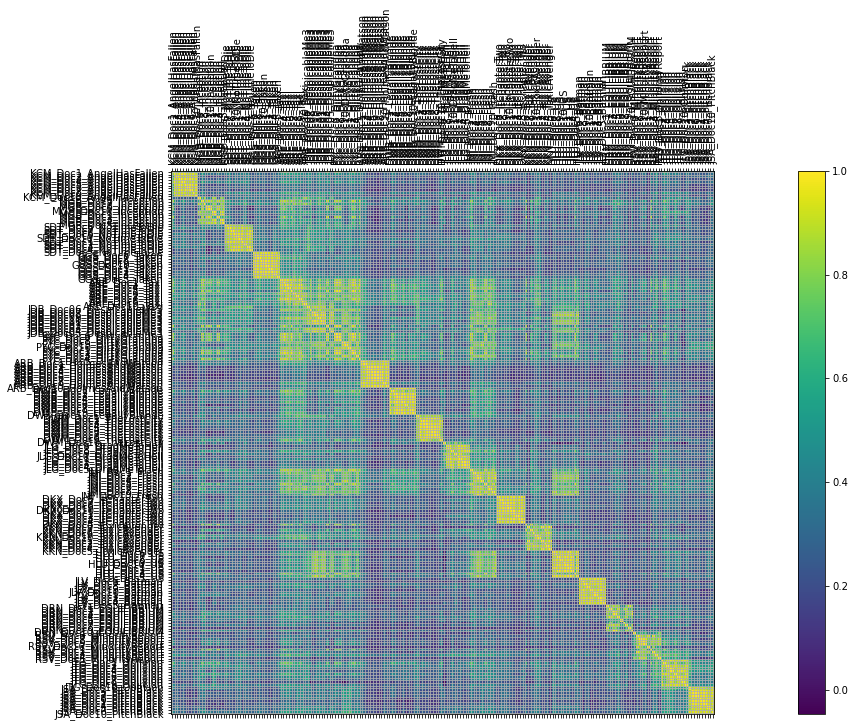

In [42]:
model_20topic_10words =plot_lsa(20, 10)

### Compare LSA Model Coherence

In [43]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '0.427*"movie" + 0.187*"would" + 0.173*"action" + 0.143*"equilibrium" + 0.143*"first" + 0.142*"movies" + 0.123*"scene" + 0.111*"people" + 0.110*"scenes" + 0.109*"story"'), (1, '-0.435*"anderton" + -0.285*"minority" + -0.261*"report" + -0.211*"precrime" + -0.209*"spielberg" + 0.199*"movie" + -0.174*"technology" + -0.154*"future" + 0.131*"equilibrium" + 0.096*"matrix"'), (2, '-0.366*"equilibrium" + -0.232*"matrix" + -0.189*"preston" + -0.128*"anderton" + -0.127*"christian" + 0.125*"horror" + 0.116*"batman" + -0.115*"cleric" + 0.094*"makes" + -0.094*"scene"'), (3, '-0.469*"movie" + 0.276*"preston" + 0.207*"batman" + 0.154*"equilibrium" + 0.148*"world" + 0.147*"action" + -0.128*"toxic" + 0.127*"emotions" + -0.114*"movies" + 0.112*"sense"'), (4, '-0.537*"batman" + -0.292*"joker" + -0.209*"bruce" + -0.175*"keaton" + -0.171*"gotham" + -0.170*"wayne" + -0.141*"nicholson" + -0.128*"movie" + -0.124*"burton" + -0.123*"vicki"'), (5, '0.366*"toxic" + 0.225*"horror" + 0.217*"avenger" + -0.199*"

### Latent Dirichlet Allocation - Research Number of Topics and Number of Words

In [44]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=4
words=20
#####################################

[(0, '0.005*"movie" + 0.003*"black" + 0.003*"planet" + 0.002*"pitch" + 0.002*"never" + 0.002*"anderton" + 0.002*"story" + 0.002*"scene" + 0.002*"would" + 0.002*"character" + 0.002*"first" + 0.002*"scenes" + 0.002*"little" + 0.002*"things" + 0.002*"characters" + 0.002*"though" + 0.002*"riddick" + 0.002*"alien" + 0.002*"three" + 0.002*"could"'), (1, '0.006*"movie" + 0.004*"action" + 0.003*"story" + 0.003*"world" + 0.003*"would" + 0.003*"people" + 0.003*"first" + 0.002*"still" + 0.002*"makes" + 0.002*"films" + 0.002*"little" + 0.002*"movies" + 0.002*"loretta" + 0.002*"years" + 0.002*"could" + 0.002*"something" + 0.002*"characters" + 0.002*"really" + 0.002*"though" + 0.002*"character"'), (2, '0.011*"movie" + 0.004*"action" + 0.003*"would" + 0.003*"never" + 0.003*"first" + 0.003*"character" + 0.003*"films" + 0.003*"movies" + 0.002*"bryan" + 0.002*"world" + 0.002*"toxic" + 0.002*"people" + 0.002*"taken" + 0.002*"characters" + 0.002*"could" + 0.002*"something" + 0.002*"story" + 0.002*"almost"

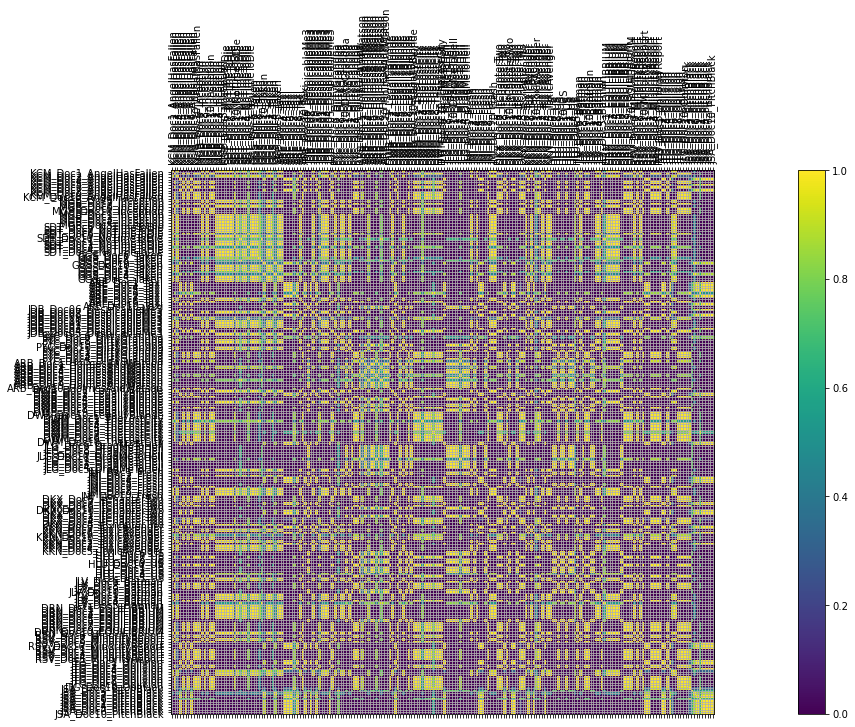

In [45]:
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model( processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

### Compare LDA Model Coherence

In [69]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    
coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '0.005*"movie" + 0.003*"things" + 0.002*"scene" + 0.002*"first" + 0.002*"might" + 0.002*"character" + 0.002*"chapter" + 0.002*"alison" + 0.002*"pennywise" + 0.002*"would"'), (1, '0.006*"movie" + 0.003*"action" + 0.003*"people" + 0.003*"preston" + 0.003*"world" + 0.003*"loretta" + 0.003*"equilibrium" + 0.003*"years" + 0.003*"first" + 0.003*"story"'), (2, '0.012*"movie" + 0.005*"toxic" + 0.004*"movies" + 0.003*"would" + 0.003*"action" + 0.003*"character" + 0.003*"avenger" + 0.003*"films" + 0.003*"people" + 0.003*"great"'), (3, '0.007*"movie" + 0.004*"would" + 0.004*"blonde" + 0.004*"witherspoon" + 0.003*"first" + 0.003*"scene" + 0.003*"equilibrium" + 0.003*"scenes" + 0.003*"harvard" + 0.003*"going"'), (4, '0.008*"movie" + 0.005*"horror" + 0.004*"story" + 0.003*"first" + 0.003*"would" + 0.003*"never" + 0.003*"action" + 0.003*"steve" + 0.003*"fresh" + 0.002*"scene"'), (5, '0.007*"batman" + 0.006*"holmes" + 0.004*"movie" + 0.004*"would" + 0.004*"watson" + 0.004*"joker" + 0.003*"action"